# MTH 4480 HW4
Devon DeJohn, Fall 2019

### Exercise 1
> Construct a Divided Differences code. Then solve the following problems utilizing it.

#### See source code at last page.

### Exercise 2
> Determine the interpolating polynomial of degree 3 for the following data set:

| x    | f(x)    |
| :--: | :-----: |
| -0.1 | 1.81818 |
| 0.0  | 2.00000 |
| 0.2  | 2.50000 |
| 0.3  | 2.85714 |

```julia
data = [(-0.1, 1.81818), (0., 2.), (0.2, 2.5), (0.3, 2.85714)]

f, m = ndd(data=data)
println(ndd_print(m))
println("p(0.35) = $(f(0.35))")
```

`output`

```julia
p(x) = 1.818 + 1.818*(x + 0.1) + 2.273*(x + 0.1)*(x - 0.0) + 3.247*(x + 0.1)*(x - 0.0)*(x - 0.2)
p(0.35) = 3.0710175
```

### Exercise 3
> Add $f(0.35) = 3.07692$ to the above table and construct the interpolating polynomial of degree 4.

`input`

```julia
p = (0.35, 3.07692)

f, m = ndd_add(m=m, p=p)
println(ndd_print(m))
println("p(0.35) = $(f(0.35))")
```

`output`

```julia
p(x) = 1.818 + 1.818*(x + 0.1) + 2.273*(x + 0.1)*(x - 0.0) + 3.247*(x + 0.1)*(x - 0.0)*(x - 0.2) + 4.997*(x + 0.1)*(x - 0.0)*(x - 0.2)*(x - 0.3)
p(0.35) = 3.0769200000000003
```

### Exercise 4
> Plot the two polynomials you've constructed with the actual function $f(x) = 2/(1-x)$
>
> a. Was the degree-4 polynomial better than degree-3?
>
> b. Compare their errors: Plot the absolute error. Does this match your expectations? What do you notice about polynomial interpolation?

In [2]:
data = [(-0.1, 1.81818), (0., 2.), (0.2, 2.5), (0.3, 2.85714)]

N3, m = ndd(data=data)
N4, m = ndd_add(m=m, p=(0.35, 3.07692))

funcs=[(N3, N4)]
names=["Newton"];

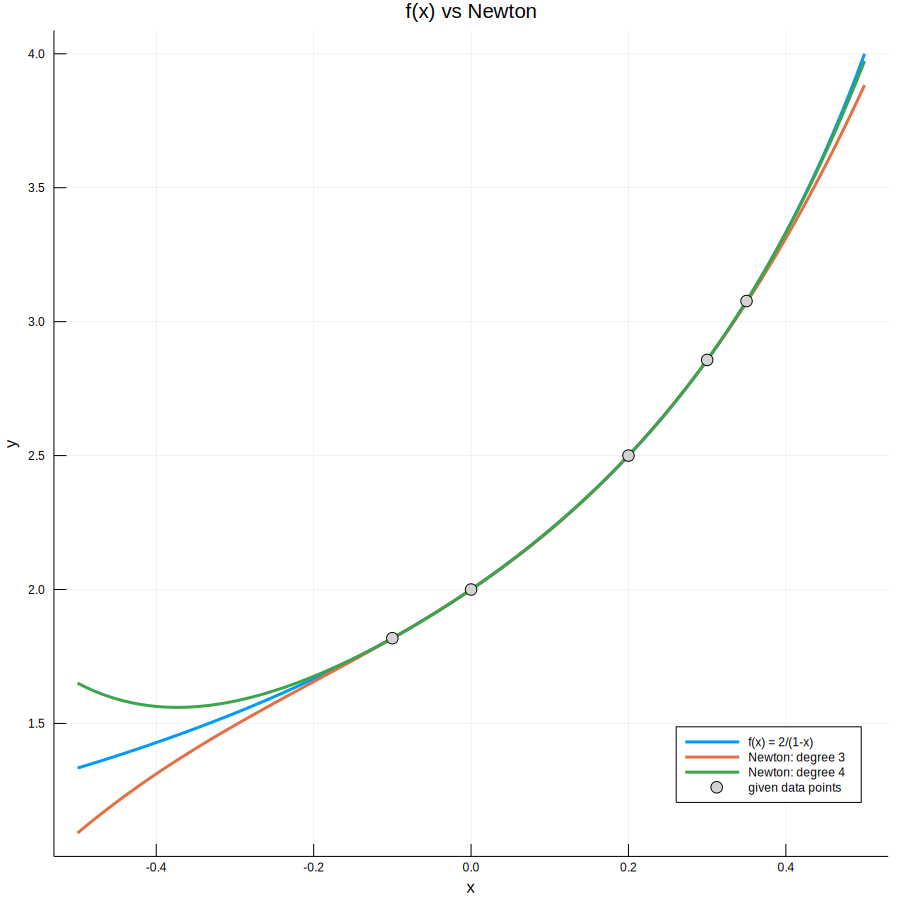

In [3]:
make_plot(f=x-> 2/(1-x), funcs=funcs, names=names, x_range=-0.5:0.01:0.5)

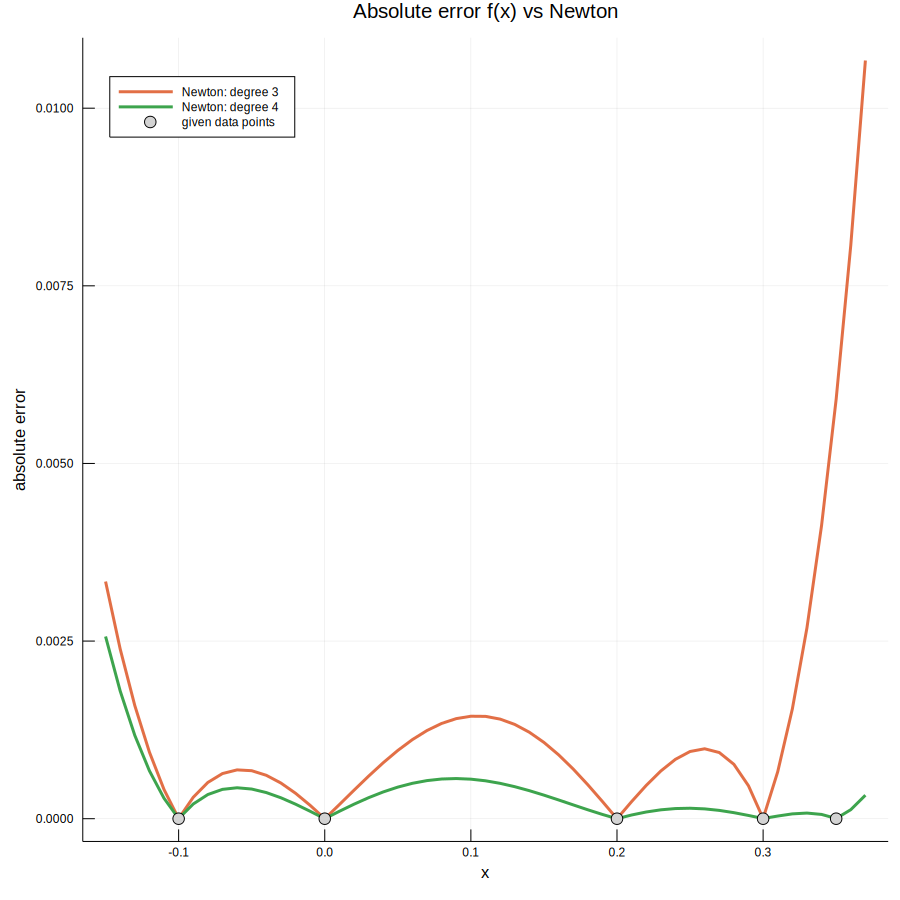

In [4]:
error_plot(f=x-> 2/(1-x), funcs=funcs, names=names, x_range=-0.15:0.01:0.375)

We can see that both polynomials are very accurate in the domain where the data points are located and as expected, the error on the degree-4 polynomial is lower.

Something else that tells us a lot about polynomial interpolation is the "bouncing" we see between the data points. Both polynomials have an absolute error of virtually zero* at the data points, and between them we see the error grow, and then shrink again as we approach the next data point. Beyond the data we can see that the error accumulates rapidly.

\* I say virtually since we do still suffer round-off error using the computer-generated polynomials. On paper, the error would be exactly zero.

### Exercise 5
> Compare with the polynomial formed by the Lagrange and monomial interpolation schemes. Explain the results you see, and why you see them.



In [5]:
data = [(-0.1, 1.81818), (0., 2.), (0.2, 2.5), (0.3, 2.85714)]
extra_point = (0.35, 3.07692)

# Lagrange and Monomial; degree 3
L3 = lag(data=data)
M3 = mono(data=data)

# Newton degrees 3, 4
N3, m = ndd(data=data)
N4, m = ndd_add(m=m, p=(0.35, 3.07692))

# Add the extra point, Lagrange and Monomial; degree 4
push!(data, extra_point)
L4 = lag(data=data)
M4 = mono(data=data)

funcs = [(N3, N4), (L3, L4), (M3, M4)]
names = ["Newton", "Lagrange", "Monomial"];

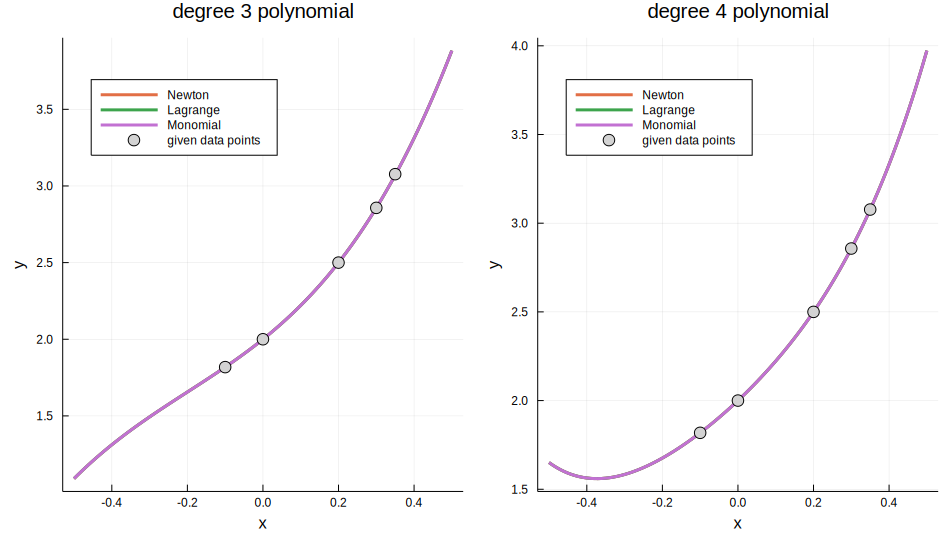

In [6]:
multi_plot(f=x-> 2/(1-x), funcs=funcs, names=names, x_range=-0.5:0.01:0.5)

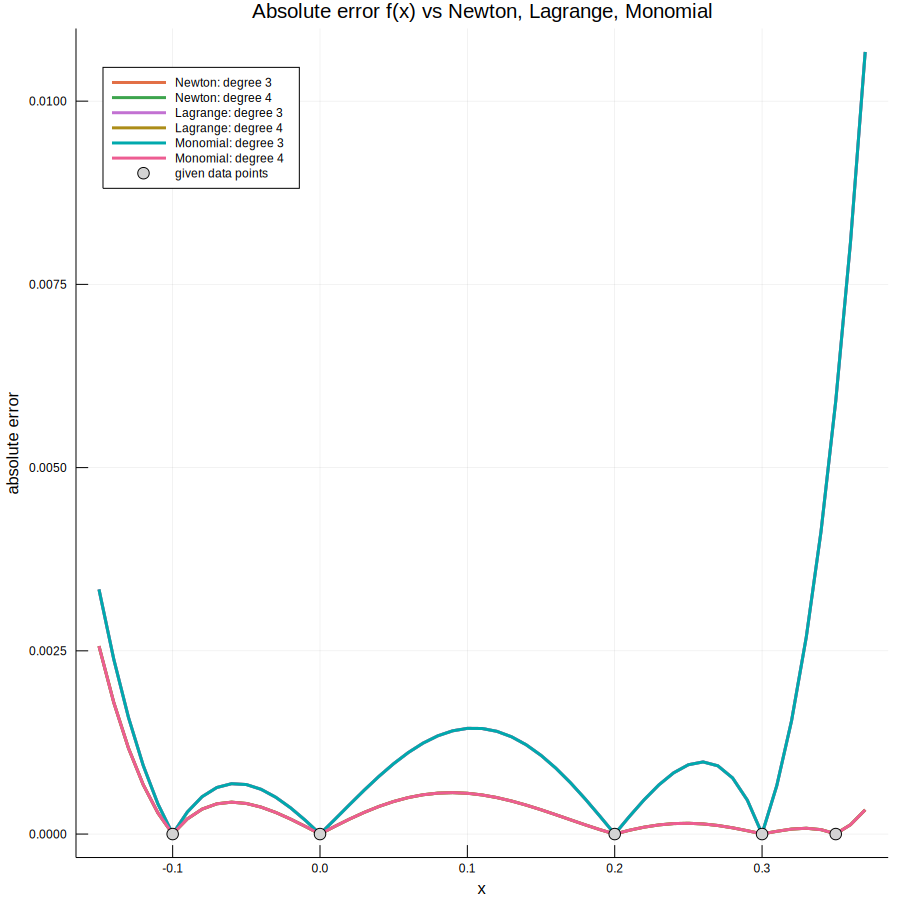

In [7]:
error_plot(f=x-> 2/(1-x), funcs=funcs, names=names, x_range=-0.15:0.01:0.375)

We see no difference between the Monomial, Lagrange, and Newton polynomials. This is what we would expect, since given some set of $n$ data points, there exists a **unique** polynomial of degree $n-1$ that passes through the given points.


## Source code

In [1]:
using LinearAlgebra
using Plots
gr()


# Newton's divided difference polynomial
function ndd(; data)
    n = length(data)
    # initialize nxm matrix
    m = zeros(Float64, n, n)
    
    # unzips list of (x,y) coords into separate lists
    # set first column of DD matrix to f(x) for x in xx
    xx, m[:,1] = map(y -> map(x -> x[y], data), 1:2)

    # generate lower triangular NDD matrix
    for i in 2:n
        for j in 2:i
            m[i,j] = (m[i,j-1]-m[i-1,j-1])/(xx[i]-xx[i-j+1])
        end
    end
    
    # return a lambda in x: 
    # sum the diagonal entries as coefficients
    # on the generated Newton polynomial
    return x-> sum(m[i,i]*poly(i, x, xx) for i in 1:n), hcat(xx, m)
end


# Helper function to generate Newton polynomials
function poly(i, x, xx)
    p = 1
    for j in 1:i-1
        p *= (x-xx[j]) # (x - xj) for j from 1 to i-1
    end
    return p
end


# helper function to add new point to existing divided difference matrix
function ndd_add(; m::Matrix, p::Tuple)
    # concatenate m with a row of zeros at the bottom
    m = vcat(m, fill(0.0, size(m, 2))')
    
    # concatenate m with a column of zeros on the right
    m = hcat(m, fill(0.0, size(m, 1)))
    
    # unpack x,y into first two columns of m
    m[end,1], m[end,2] = p

    # perform divided differences on the last row
    for j in 3:size(m,2)
        m[end, j] = (m[end,j-1]-m[end-1,j-1])/(m[end, 1]-m[end-j+2,1])
    end

    # same return type as ndd
    return x-> sum(m[i,i+1]*poly(i, x, m[:, 1]) for i in 1:size(m,1)), m
end


# print the interpolating polynomial
function ndd_print(m::Matrix)
    xx = m[:,1]
    diag = [round(m[i,i+1], digits=3) for i in 1:size(m, 1)]
    ndd_repr = []
    for i in 1:length(diag)
        push!(ndd_repr, "$(diag[i])")
        for j in 1:i-1
            if xx[j] < 0
                ndd_repr[i] *=  "*(x+$(-xx[j]))"
            else
                ndd_repr[i] *=  "*(x-$(xx[j]))"
            end
        end
    end
    return "p(x) = " * join(ndd_repr, " + ")
end


# Lagrange polynomial interpolation
function lag(; data)
    n = length(data)
    xx, yy = map(y -> map(x -> x[y], data), 1:2)

    # Lagrange basis polynomial helper
    function lbp(j, x)
        p = 1
        for i in (1:n)[1:end .!= j]
            p *= (x - xx[i])/(xx[j] - xx[i])
        end
        return p
    end

    return x -> sum(yy[j]*lbp(j, x) for j in 1:n)
end


# monomial polynomial interpolation (silly name)
function mono(; data)
    n = length(data)
    xx, yy = map(y -> map(x -> x[y], data), 1:2)

    m = [x^p for x in xx, p in 0:n-1]
    cc = m\yy
    
    return x -> sum(cc[i]*x^(i-1) for i in 1:length(cc))
end


# plot any number of interpolated functions against f(x) 
function make_plot(; f, funcs, names, x_range::StepRangeLen)
    # x-range to plot
    xx = [x for x in x_range]
    
    p = plot(
        xx, f.(xx), label="f(x) = 2/(1-x)",
        lw=3, xlabel="x", ylabel="y",
        size=(900,900),
        legend=:bottomright,
        title="f(x) vs " * join(names, ", ")
    )
    
    for i in 1:length(funcs)
        # unpack functions into degree 3, 4
        f3, f4 = funcs[i]
        name = names[i]
        lbl = "$(name): degree "
        plot!(p, xx, f3.(xx), lw=3, label=lbl*"3")
        plot!(p, xx, f4.(xx), lw=3, label=lbl*"4")
    end
    
    scatter!(p, [-0.1, 0, 0.2, 0.3, 0.35], [1.81818, 2., 2.5, 2.85714, 3.07692],
        ms=6, mc="lightgrey", label="given data points")
    p
end


# error plotter
function error_plot(; f, funcs, names, x_range::StepRangeLen)
    # x-range to plot
    xx = [x for x in x_range]
    
    p = plot(
        [], [], label="",
        lw=3, xlabel="x", ylabel="absolute error",
        size=(900,900),
        legend=:topleft,
        title="Absolute error f(x) vs " * join(names, ", ")
    )
    
    for i in 1:length(funcs)
        # unpack functions into degree 3, 4
        f3, f4 = funcs[i]
        name = names[i]
        lbl = "$(name): degree "
        plot!(p, xx, abs.(f.(xx) - f3.(xx)), lw=3, label=lbl*"3")
        plot!(p, xx, abs.(f.(xx) - f4.(xx)), lw=3, label=lbl*"4")
    end
    
    scatter!(p, [-0.1, 0, 0.2, 0.3, 0.35], [0., 0., 0., 0., 0.],
        ms=6, mc="lightgrey", label="given data points")
    p
end


# subplots for degree 3 and degree 4 polynomials
function multi_plot(; f, funcs, names, x_range::StepRangeLen)
    # x-range to plot
    xx = [x for x in x_range]
    
    p3=plot([], [], label="", title="degree 3 polynomial", xlabel="x", ylabel="y")
    p4=plot([], [], label="", title="degree 4 polynomial", xlabel="x", ylabel="y")
    
    for i in 1:length(funcs)
        # unpack functions into degree 3, 4
        f3, f4 = funcs[i]
        name = names[i]
        plot!(p3, xx, f3.(xx), lw=3, label=name)
        plot!(p4, xx, f4.(xx), lw=3, label=name)
    end

    scatter!(p3, [-0.1, 0, 0.2, 0.3, 0.35], [1.81818, 2., 2.5, 2.85714, 3.07692],
        ms=6, mc="lightgrey", label="given data points")

    scatter!(p4, [-0.1, 0, 0.2, 0.3, 0.35], [1.81818, 2., 2.5, 2.85714, 3.07692],
        ms=6, mc="lightgrey", label="given data points")

    p=plot(p3, p4, layout=(1,2), size=(950,550), legend=:topleft)
    p
end;